# Prepare

In [ ]:
!pip install pyspark

# EDA

## Import data

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, sum, isnull, when, count, lit, rank, dense_rank, to_date, month
from pyspark.sql.window import Window

spark = (
    SparkSession.builder
    .appName("LinkedInBigDataAnalysi")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "10g")
    .getOrCreate()
)

### Generate Dataframe from the csv data.

In [3]:
file_path_job_skills = "../resources/job_skills.csv"
file_path_job_summary = "../resources/job_summary.csv"
file_path_job_postings = "../resources/linkedin_job_postings.csv"

df_job_skills = spark.read.csv(file_path_job_skills, header=True, escape='"', inferSchema=True)
df_job_summary = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .option("multiline","true")\
  .option("quote", '"')\
  .option("escape", '\"')\
  .load(file_path_job_summary)
df_job_postings = spark.read.csv(file_path_job_postings, header=True, escape='"', inferSchema=True)


## Check top data

In [4]:
df_job_skills.show(20,0)

+------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                               

In [5]:
df_job_summary.show(20,0)

+-------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
df_job_postings.show(20,0)

+---------------------------------------------------------------------------------------------------------------------------------+-----------------------------+-----------+-------+---------------+--------------------------------------------------------------------------+-------------------------------------+----------------------------------+----------+---------------+--------------+------------------------------------+----------+--------+
|job_link                                                                                                                         |last_processed_time          |got_summary|got_ner|is_being_worked|job_title                                                                 |company                              |job_location                      |first_seen|search_city    |search_country|search_position                     |job_level |job_type|
+-------------------------------------------------------------------------------------------------------------

### Define and verify the schema of the dataset

In [7]:
# Display schema of the dataframes
print("Schema of df_job_skills:")
df_job_skills.printSchema()

print("Schema of df_job_summary:")
df_job_summary.printSchema()

print("Schema of df_job_postings:")
df_job_postings.printSchema()

Schema of df_job_skills:
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

Schema of df_job_summary:
root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)

Schema of df_job_postings:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)



## Print the number of rows and columns.

In [8]:
# Print the number of rows and columns
print(f"df_job_skills: {df_job_skills.count()} rows, {len(df_job_skills.columns)} columns")
print(f"df_job_summary: {df_job_summary.count()} rows, {len(df_job_summary.columns)} columns")
print(f"df_job_postings: {df_job_postings.count()} rows, {len(df_job_postings.columns)} columns")

df_job_skills: 1296381 rows, 2 columns


df_job_summary: 1297332 rows, 2 columns
df_job_postings: 1348488 rows, 14 columns


## Obtain the descriptive statistics

In [9]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_skills:")
df_job_skills.describe().show()

Descriptive statistics for df_job_skills:


+-------+--------------------+-------------------------------+
|summary|            job_link|                     job_skills|
+-------+--------------------+-------------------------------+
|  count|             1296381|                        1294374|
|   mean|                NULL|                           NULL|
| stddev|                NULL|                           NULL|
|    min|https://ae.linked...|           $1952 per week, T...|
|    max|https://za.linked...|志愿服务, 沟通, 陪伴, 临终服...|
+-------+--------------------+-------------------------------+



In [10]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_summary:")
df_job_summary.describe().show()

Descriptive statistics for df_job_summary:


+-------+--------------------+--------------------+
|summary|            job_link|         job_summary|
+-------+--------------------+--------------------+
|  count|             1297332|             1297332|
|   mean|                NULL|                NULL|
| stddev|                NULL|                NULL|
|    min|https://ae.linked...|! CURRENTLY SEEKI...|
|    max|https://za.linked...|🪠 We invite full...|
+-------+--------------------+--------------------+



In [11]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_postings:")
df_job_postings.describe().show()

25/12/11 11:47:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Descriptive statistics for df_job_postings:


+-------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|summary|            job_link| last_processed_time|         got_summary|   got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|search_city|search_country| search_position| job_level|job_type|
+-------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|  count|             1348488|             1348488|             1348488|   1348488|        1348488|             1348488|             1348443|             1348435|   1348454|    1348420|       1348420|         1348420|   1348420| 1348420|
|   mean|                NULL|                NU

# EDA Deep Dive

In [12]:
# Create a new column with the primary skill
df_job_skills_with_primary = df_job_skills.withColumn("primary_skill", split(col("job_skills"), ",")[0])
df_job_skills_with_primary.show(5, 0)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------+
|job_link                                                                                                                       |job_skills              

In [13]:
# Aggregate functions
# Count of jobs by job level
df_job_postings.groupBy("job_level").count().show()

# Count of jobs by job type
df_job_postings.groupBy("job_type").count().show()

+----------+-------+
| job_level|  count|
+----------+-------+
|      NULL|     68|
| Associate| 144009|
|Mid senior|1204411|
+----------+-------+

+--------+-------+
|job_type|  count|
+--------+-------+
|  Remote|   4259|
|  Onsite|1337599|
|    NULL|     68|
|  Hybrid|   6562|
+--------+-------+



In [14]:
# Grouping and Sorting
# Group by company and count job postings, then sort
company_counts = df_job_postings.groupBy("company").count().sort("count", ascending=False)
company_counts.show(10)

+--------------------+-----+
|             company|count|
+--------------------+-----+
|     Health eCareers|41598|
|   Jobs for Humanity|27680|
|   TravelNurseSource|16142|
|      Dollar General|14815|
|        PracticeLink| 9738|
|      Energy Jobline| 9365|
|Gotham Enterprise...| 8935|
|               Jobot| 8713|
|       ClearanceJobs| 8599|
|          McDonald's| 8125|
+--------------------+-----+
only showing top 10 rows


## JOIN dataframe on job link

In [15]:
# Join df_job_postings and df_job_skills
df_joined = df_job_postings.join(df_job_skills, "job_link", "inner")
df_joined.show(5)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen| search_city|search_country|   search_position| job_level|job_type|          job_skills|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|https://ae.linked...|2024-01-21 07:21:...|          t|      t|              f|        EVS Operator|              Sundus|Abu Dhabi, Abu Dh...|2024-01-17|Saint Joseph| United States|     Unit Operator|Mid senior|  Onsite|EVS, EVS Operator...|
|https://ae.linked...|2024-01-21

## Count Missing Values

In [16]:
# Count missing values in df_job_postings
df_job_postings.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_postings.columns]).show()

# Count missing values in df_job_summary
df_job_summary.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_summary.columns]).show()

# Count missing values in df_job_skills
df_job_skills.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_skills.columns]).show()

+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|       0|                  0|          0|      0|              0|        0|     45|          53|        34|         68|            68|             68|       68|      68|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+



+--------+-----------+
|job_link|job_summary|
+--------+-----------+
|       0|          0|
+--------+-----------+

+--------+----------+
|job_link|job_skills|
+--------+----------+
|       0|      2007|
+--------+----------+



## Fill missing values in job summary dataframe

In [26]:
# Fill missing values in df_job_summary

df_job_summary.filter(col("job_summary") == "No summary available").show(5)
df_job_summary_cleaned = df_job_summary.fillna({"job_summary": "No summary available"})
df_job_summary_cleaned.filter(col("job_summary") == "No summary available").show(5)

+--------+-----------+
|job_link|job_summary|
+--------+-----------+
+--------+-----------+



+--------+-----------+
|job_link|job_summary|
+--------+-----------+
+--------+-----------+



## Drop rows missing job skills

In [18]:
# Drop rows with missing job_skills in df_job_skills
df_job_skills_cleaned = df_job_skills.dropna(subset=["job_skills"])
print(f"Original df_job_skills count: {df_job_skills.count()}")
print(f"Cleaned df_job_skills count: {df_job_skills_cleaned.count()}")

Original df_job_skills count: 1296381
Cleaned df_job_skills count: 1294374


## Drop rows missing job postings

In [19]:
# Drop rows with missing values in key columns of df_job_postings
df_job_postings_cleaned = df_job_postings.dropna(subset=["job_title", "company", "job_location"])
print(f"Original df_job_postings count: {df_job_postings.count()}")
print(f"Cleaned df_job_postings count: {df_job_postings_cleaned.count()}")

Original df_job_postings count: 1348488
Cleaned df_job_postings count: 1348424


## Geographic Analysis

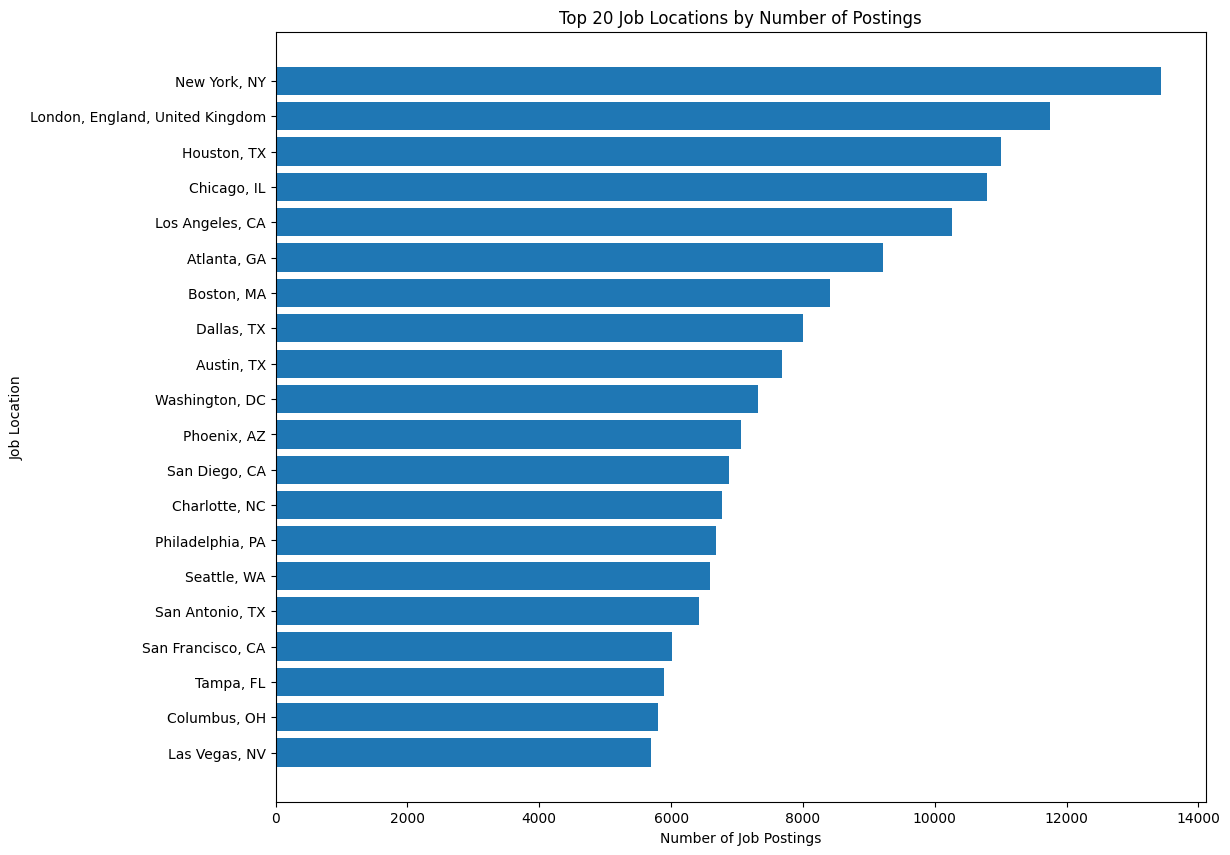

In [22]:
# Group by job location and count the number of job postings
location_counts = df_job_postings_cleaned.groupBy('job_location').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for plotting the top 20 locations
top_locations_pd = location_counts.limit(20).toPandas()

# Plotting the top 20 job locations
plt.figure(figsize=(12, 10))
plt.barh(top_locations_pd['job_location'], top_locations_pd['count'])
plt.xlabel('Number of Job Postings')
plt.ylabel('Job Location')
plt.title('Top 20 Job Locations by Number of Postings')
plt.gca().invert_yaxis()
plt.show()

## Skills Analysis

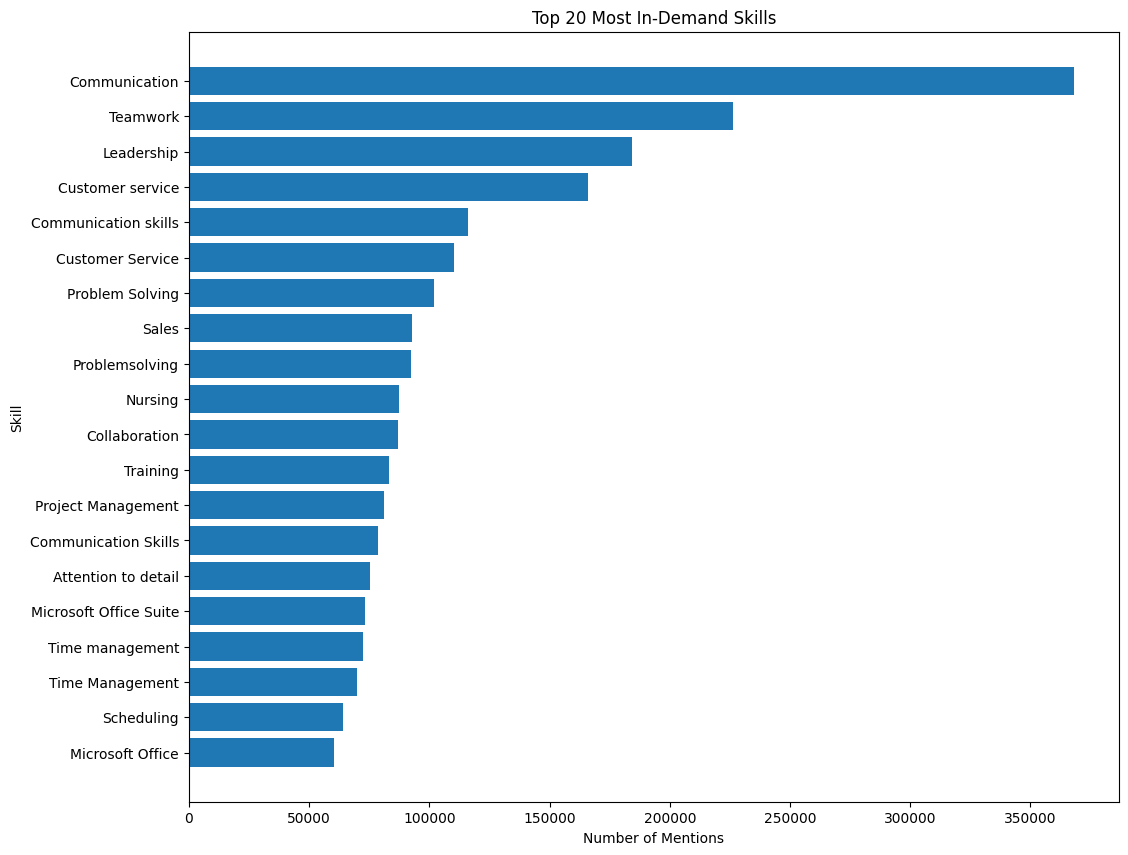

In [23]:
from pyspark.sql.functions import explode, split, trim

# Split the job_skills string into an array of skills, trim whitespace, and explode the array
skills_df = df_job_skills_cleaned.withColumn('skill', explode(split(col('job_skills'), ',')))
skills_df = skills_df.withColumn('skill', trim(col('skill')))

# Group by skill and count the occurrences
skill_counts = skills_df.groupBy('skill').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for plotting the top 20 skills
top_skills_pd = skill_counts.limit(20).toPandas()

# Plotting the top 20 skills
plt.figure(figsize=(12, 10))
plt.barh(top_skills_pd['skill'], top_skills_pd['count'])
plt.xlabel('Number of Mentions')
plt.ylabel('Skill')
plt.title('Top 20 Most In-Demand Skills')
plt.gca().invert_yaxis()
plt.show()

## Job Type Trends

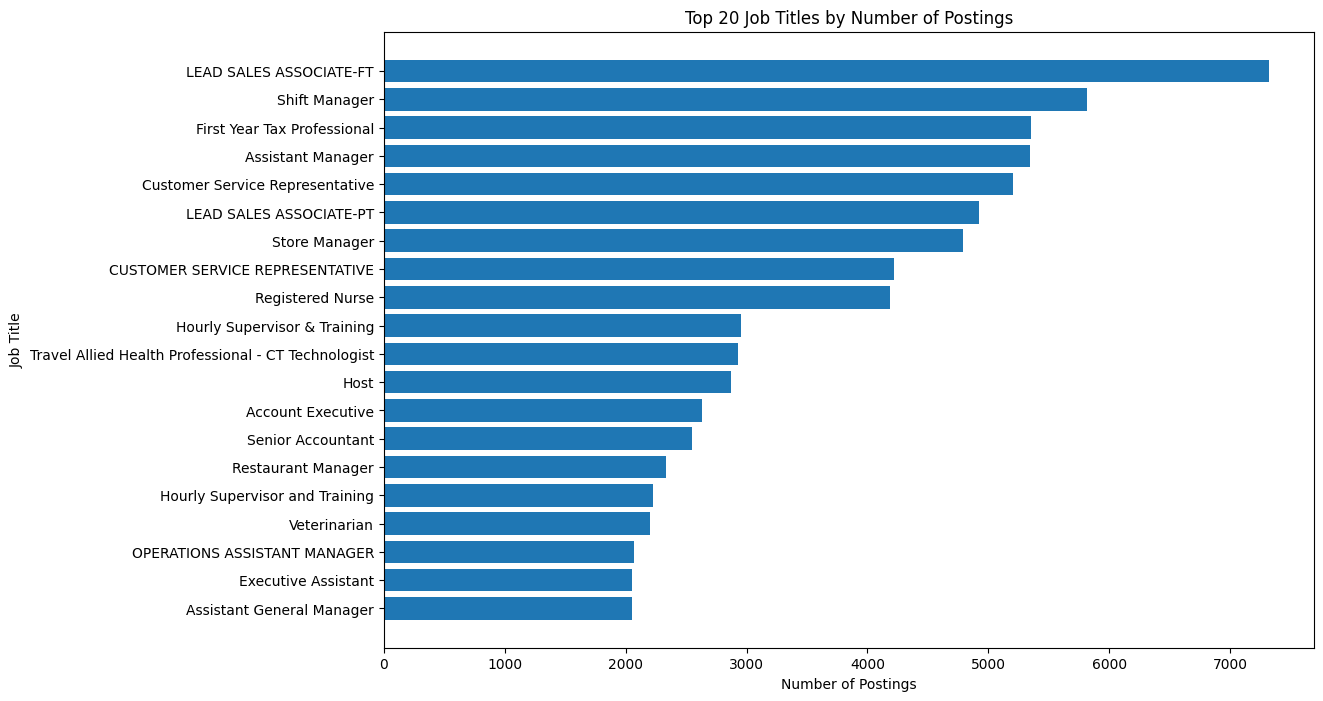

In [25]:
import matplotlib.pyplot as plt

# Rank job titles by count
job_title_ranking = df_job_postings_cleaned.groupBy('job_title').count().orderBy('count', ascending=False)
job_title_ranking_pd = job_title_ranking.limit(20).toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(job_title_ranking_pd['job_title'], job_title_ranking_pd['count'])
plt.xlabel('Number of Postings')
plt.ylabel('Job Title')
plt.title('Top 20 Job Titles by Number of Postings')
plt.gca().invert_yaxis()
plt.show()